In [1]:
# import pre-processed data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import applications, layers, losses, optimizers, Model
from tensorflow.keras.models import Sequential
import keras_toolkit as kt
from sklearn.model_selection import train_test_split
from textwrap import wrap


2023-04-05 15:02:05.031799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 15:02:07.725633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 15:02:07.726552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 15:02:12.600190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# # change tensorflow device to GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Pre-process image data so that it can be used in the model

In [2]:
PATH = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/'
PATH_TO_IMG = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'
PATH_TO_TEST = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test_images/'
os.listdir(PATH)

['train.csv',
 'sample_submission.csv',
 'train_images',
 'test.csv',
 'test_images']

In [3]:
# how many images are there in trainig set
len(os.listdir(PATH_TO_IMG))

32411

## Show some images

In [5]:
COMPUTE_CV = True
if len(pd.read_csv(PATH + 'test.csv')) > 3: COMPUTE_CV = False

In [6]:
if COMPUTE_CV:
    dataset = pd.read_csv(PATH + 'train.csv')
    tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict() 
    dataset['target'] = dataset.label_group.map(tmp) # map the posting_ids that have same image
else:    
    dataset = pd.read_csv(PATH + 'test.csv')

In [7]:
dataset.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [8]:
def show_random_img():
    # choose randomly two instances per each class
    labels_to_show = np.random.choice(dataset.label_group.unique(), 
                                      replace=False, size=27)
    img_to_show = []
    for label in labels_to_show:
        rows = dataset[dataset.label_group==label].copy()
        pair = np.random.choice([i for i in range(len(rows))], 
                                    replace=False, size=2)
        img_pair = rows.iloc[pair][['image', 'title']].values
        
        img_to_show += list(img_pair)
    
    fig, axes = plt.subplots(figsize = (18, 12), nrows=4,ncols=6)
    for imp, ax in zip(img_to_show, axes.ravel()):
        img = cv2.imread(PATH_TO_IMG + imp[0])
        title = '\n'.join(wrap(imp[1], 20))
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()

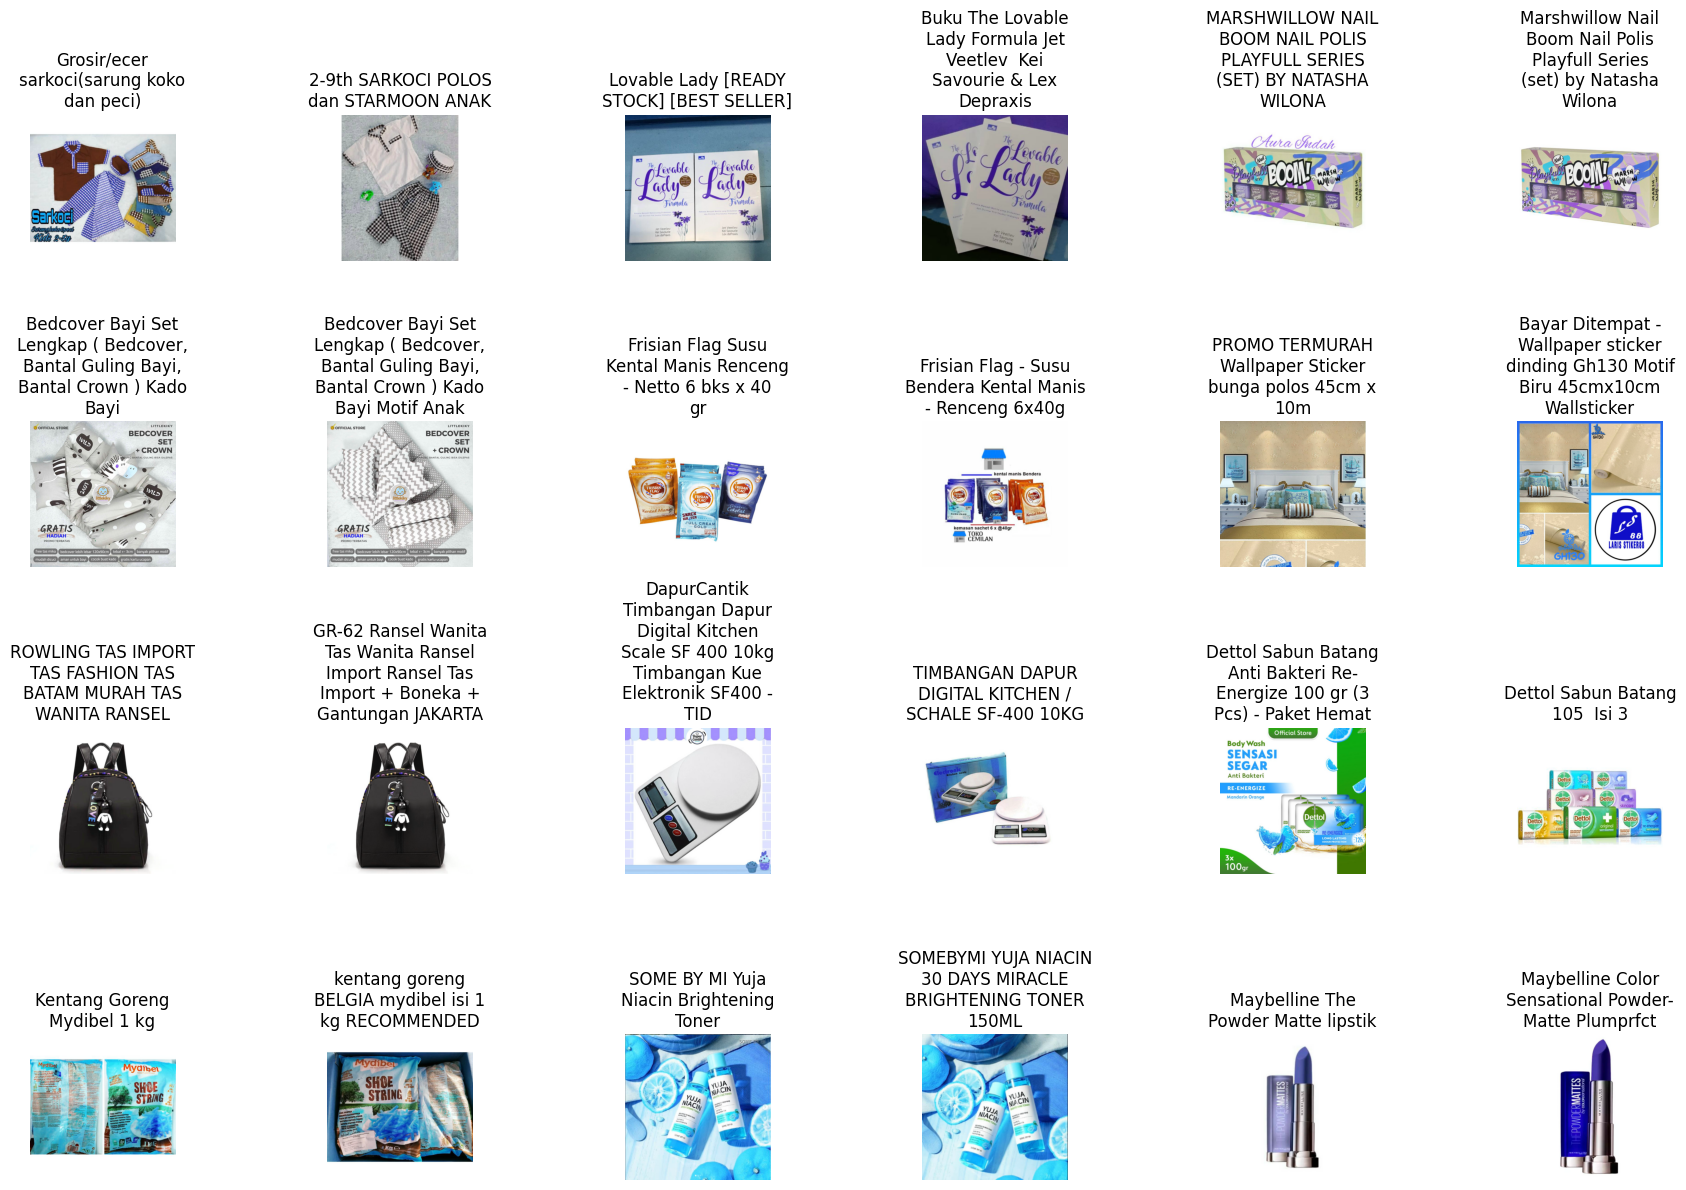

In [9]:
if COMPUTE_CV:
    show_random_img()

### [Done] Reorganize the data into a directory structure that can be used by the model

In [10]:
# create 20_intermediate_data folder if not exist
# if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data'):
#     os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data')
#     print("Folder Created")
# else:
#     print("Folder already exists")

In [ ]:
# create folder for each class
# for label in dataset.label_group.unique():
#     if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label)):
#         os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label))
#         print("Folder Created")
#     else:
#         print("Folder already exists")

In [ ]:
# copy images to their respective class folder
# for label in dataset.label_group.unique():
#     for img in dataset[dataset.label_group==label].image.values:
#         os.system('cp ' + PATH_TO_IMG + img + ' /workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label) + '/')
#         print("Image copied")

## Set up and Train the Model

In [4]:
# create train and validation set
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=17,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=17,
)

Found 32459 files belonging to 11014 classes.
Using 25968 files for training.


2023-04-05 15:03:18.759653: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 32459 files belonging to 11014 classes.
Using 6491 files for validation.


In [5]:
# check the image size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-04-05 15:03:22.484280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25968]
	 [[{{node Placeholder/_4}}]]
2023-04-05 15:03:22.484811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25968]
	 [[{{node Placeholder/_0}}]]


(32, 256, 256, 3)
(32, 11014)


In [6]:
num_classes = len(train_ds.class_names)
print(f"We have {num_classes} classes.")

We have 11014 classes.


In [7]:
class_names = train_ds.class_names
# print(class_names)

### Visualize 6 images from the training set

2023-04-04 22:46:16.957032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25968]
	 [[{{node Placeholder/_4}}]]
2023-04-04 22:46:16.957974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25968]
	 [[{{node Placeholder/_0}}]]


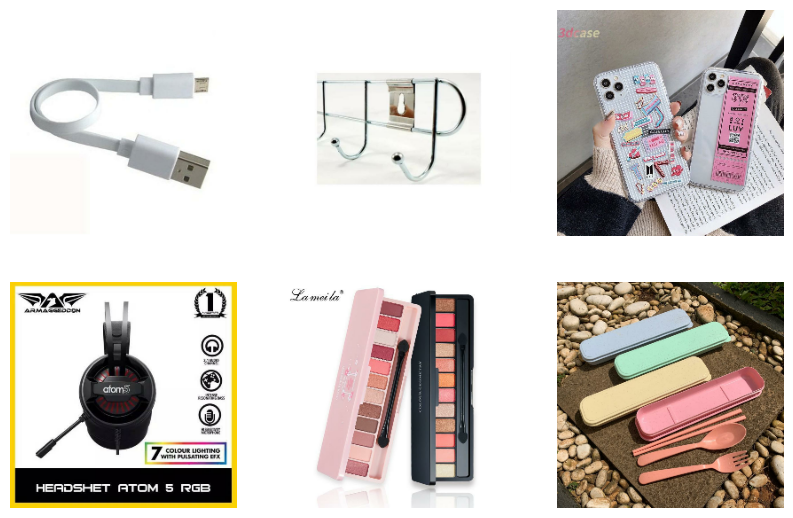

In [9]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(10, 10))

epochs=10

for images, labels in train_ds.take(1):

  for var in range(6):

    ax = plt.subplot(3, 3, var + 1)

    plotter_lib.imshow(images[var].numpy().astype("uint8"))

    plotter_lib.axis("off")

## Train and Evaluate the Model

### ResNet50

In [8]:
# import the ResNet50 model from keras

resnet = Sequential()
pretrained_model = applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),
    pooling='avg',
    classes=num_classes
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet.add(pretrained_model)
# add a fully connected layer
resnet.add(Flatten())
resnet.add(Dense(512, activation='relu'))
resnet.add(Dense(num_classes, activation='softmax'))


# save the model
# if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
#     os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
#     print("Folder Created")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")
# else:
#     print("Folder already exists")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")

In [9]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 11014)             5650182   
                                                                 
Total params: 30,264,070
Trainable params: 6,699,270
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
epochs=10 # set default to 10

In [11]:
resnet.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# setting up checkpoints
# mkdir /workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints if not exist
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
    print("Folder Created")
else:
    print("Folder already exists")
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints')
    print("Folder Created")
else:
    print("Folder already exists")
    
checkpoint_filepath = '/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints/cp-{epoch:04d}.ckpt'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_freq='epoch')

# load checkpoint if exist
# resnet.load_weights(checkpoint_filepath)

resnet.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])
# history = resnet.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])


Folder already exists
Folder already exists
Epoch 1/10
812/812 [==============================] - ETA: 0s - loss: 10.8655 - accuracy: 0.0012

2023-04-05 15:19:29.800696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6491]
	 [[{{node Placeholder/_4}}]]
2023-04-05 15:19:29.801087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6491]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy improved from -inf to 0.00108, saving model to /workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints/cp-0001.ckpt
812/812 [==============================] - 1183s 1s/step - loss: 10.8655 - accuracy: 0.0012 - val_loss: 9.3549 - val_accuracy: 0.0011
Epoch 2/10
812/812 [==============================] - ETA: 0s - loss: 9.2439 - accuracy: 0.0012
Epoch 2: val_accuracy did not improve from 0.00108
812/812 [==============================] - 1173s 1s/step - loss: 9.2439 - accuracy: 0.0012 - val_loss: 9.3967 - val_accuracy: 0.0011
Epoch 3/10
518/812 [==================>...........] - ETA: 5:45 - loss: 9.1842 - accuracy: 0.0014